In [1]:
% display typeset

import numpy as np
from scipy.optimize import minimize

In [2]:
def achaBt(t, tempos, B0, rho, method = "r"):
    indice = 0
    beta = B0
    
    if t <= tempos[0]:
        if method == "r":
            beta = beta * (1 - rho[indice])
        else:
            beta = beta * math.exp(- rho[indice] * t)
        return beta, indice
    
    while t >= tempos[indice]:
        if indice == len(tempos) - 1 or t < tempos[indice + 1]:
            if t == tempos[indice - 1]:
                return beta, indice
            if method == "r":
                beta = beta * (1 - rho[indice] * (t - tempos[indice - 1]) / t)
            else:
                beta = beta * math.exp(- rho[indice] * (t - tempos[indice]))
                
            return beta, indice
        
        else:
            if indice == 0:
                if method == "r":
                    beta = beta * (1 - rho[indice])
                else:
                    beta = beta * math.exp(- rho[indice] * t)
            else:
                if method == "r":
                    beta = beta * (1 - rho[indice] * (tempos[indice] - tempos[indice - 1]) / tempos[indice])
                else:
                    beta = beta * math.exp(- rho[indice] * (tempos[indice] - tempos[indice - 1]))
            
        indice += 1
    

In [10]:
def model(t, comp, params):
    # alpha e f fixos aqui
    S = comp[0]
    E = comp[1]
    I = comp[2]
    R = comp[3]
    D = comp[4]
    A = comp[5]
    
#     S, E, I, R, D, A = comp
#     B0, Ti, t0, alpha, rho, f = params
    B0 = params[0]
    Ti = params[1]
    t0 = params[2]
    alpha = params[3]
    rho = params[4]
    f = params[5]
    
    '''
        S, E, I, R e D são os compartimentos usuais.
        B0 é o valor inicial de beta
        Ti é a taxa de mortalidade
        tempos é a partição do tempo que estamos fazendo (dia inicial de cada período, sem considerar o dia 0)
        alpha é constantes
        rho é o vetor dos rho_k para cada intervalo de tempo (usados na função de beta)
        f é constante também
    '''
    N = S + E + I + R + D
    beta = B0 * (1 - rho * (t - t0) / t)
        
    dS = -beta / N * S * I
    dE = beta / N * S * I - alpha * E
    dI = alpha * E - I / Ti
    dR = (1 - f) / Ti * I
    dD = f / Ti * I
    dA = alpha * E
    
    return [
        dS,
        dE,
        dI,
        dR,
        dD,
        dA
    ]

/opt/sagemath-9.0/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:59: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


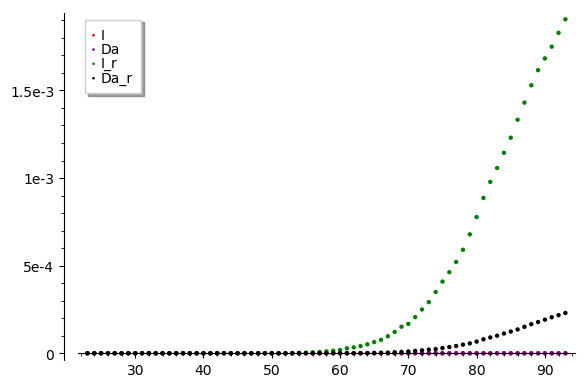

In [11]:
pop = 60461828
tspan = [23, 93]
real_data = np.genfromtxt('data.csv', delimiter=',')[1:]
data = []

for k in real_data:
    if tspan[0] <= k[0] <= tspan[1]:
        data.append((k[0], k[1]/pop, k[3]/pop))

def residual(params, data):
    inits = [1 - 1e-6, 0, 1e-6, 0, 0, 0]
    B0 = params[0]
    Ti = params[1]
    t0 = params[2]
    alpha = params[3]
    rho = params[4]
    f = params[5]
    
    T = ode_solver()
    T.function = model
    inits = [1 - 1e-6, 0, 1e-6, 0, 0, 0]
    T.ode_solve(tspan, inits, num_points = tspan[1] - tspan[0], params = [B0, Ti, t0, alpha, rho, f])
    
    model_out_0 = [(k[0], k[1][0]) for k in T.solution]
    model_out_1 = [(k[0], k[1][1]) for k in T.solution]
    model_out_2 = [(k[0], k[1][2]) for k in T.solution]
    model_out_3 = [(k[0], k[1][3]) for k in T.solution]
    model_out_4 = [(k[0], k[1][4]) for k in T.solution]
    model_out_5 = [(k[0], k[1][5]) for k in T.solution]
    
    erro_I = 0
    erro_D = 0
    for i in range(tspan[1] - tspan[0]):
        erro_I += (model_out_2[i][1] - data[i][1])**2
        erro_D += (model_out_5[i][1] - data[i][2])**2
    
    return erro_I + erro_D

x0 = [2, 14, 23, 0.2, 0.2, 0.05]

cons = ({'type': 'ineq', 'fun': lambda x0: x0[0]},
        {'type': 'ineq', 'fun': lambda x0: x0[1]},
        {'type': 'ineq', 'fun': lambda x0: x0[2] - 1},
        {'type': 'ineq', 'fun': lambda x0: - x0[2] + 30},
        {'type': 'ineq', 'fun': lambda x0: x0[3]},
        {'type': 'ineq', 'fun': lambda x0: x0[4]},
        {'type': 'ineq', 'fun': lambda x0: x0[5]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[3]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[4]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[5]}
        )

res = minimize(residual, x0, method = 'SLSQP', args = data, tol = 1e-10, constraints = cons)
params = res.x

T = ode_solver()
T.function = model
inits = [1 - 1e-6, 0, 1e-6, 0, 0, 0]
T.ode_solve(tspan, inits, num_points = tspan[1] - tspan[0], params = res.x)

model_out_0 = [(k[0], k[1][0]) for k in T.solution]
model_out_1 = [(k[0], k[1][1]) for k in T.solution]
model_out_2 = [(k[0], k[1][2]) for k in T.solution]
model_out_3 = [(k[0], k[1][3]) for k in T.solution]
model_out_4 = [(k[0], k[1][4]) for k in T.solution]
model_out_5 = [(k[0], k[1][5]) for k in T.solution]

plot0 = list_plot(model_out_0, color = 'green', pointsize = 10, alpha = 1, legend_label = 'S')
plot1 = list_plot(model_out_1, color = 'yellow', pointsize = 10, alpha = 1, legend_label = 'E')
plot2 = list_plot(model_out_2, color = 'red', pointsize = 10, alpha = 1, legend_label = 'I')
plot3 = list_plot(model_out_3, color = 'blue', pointsize = 10, alpha = 1, legend_label = 'R')
plot4 = list_plot(model_out_4, color = 'black', pointsize = 10, alpha = 1, legend_label = 'D')
plot5 = list_plot(model_out_5, color = 'purple', pointsize = 10, alpha = 1, legend_label = 'Da')

plot0.legend()
plot1.legend()
plot2.legend()
plot3.legend()
plot4.legend()
plot5.legend()

# show(plot0 + plot1 + plot2 + plot3 + plot4 + plot5)
# show(plot2 + plot5)

data1 = [(item[0], item[1]) for item in data]
data2 = [(item[0], item[2]) for item in data]

plot6 = list_plot(data1, color = 'green', pointsize = 10, alpha = 1, legend_label = 'I_r')
plot7 = list_plot(data2, color = 'black', pointsize = 10, alpha = 1, legend_label = 'Da_r')

plot6.legend()
plot7.legend()

show(plot2 + plot5 + plot6 + plot7)

/opt/sagemath-9.0/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:57: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


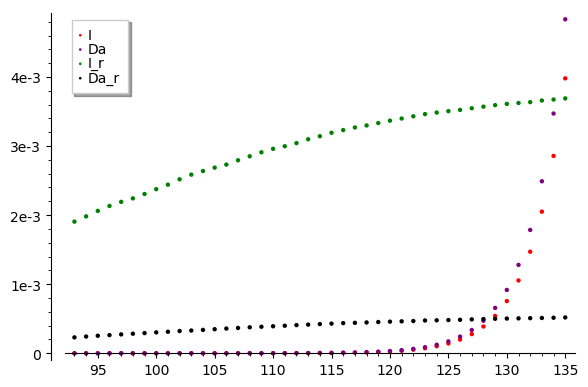

In [12]:
pop = 60461828
tspan = [93, 135]
real_data = np.genfromtxt('data.csv', delimiter=',')[1:]
data = []
inits = T.solution[-1][1]

for k in real_data:
    if tspan[0] <= k[0] <= tspan[1]:
        data.append((k[0], k[1]/pop, k[3]/pop))

def residual(params, data):
    B0 = params[0]
    Ti = params[1]
    t0 = params[2]
    alpha = params[3]
    rho = params[4]
    f = params[5]
    
    T = ode_solver()
    T.function = model
    T.ode_solve(tspan, inits, num_points = tspan[1] - tspan[0], params = [B0, Ti, t0, alpha, rho, f])
    
    model_out_0 = [(k[0], k[1][0]) for k in T.solution]
    model_out_1 = [(k[0], k[1][1]) for k in T.solution]
    model_out_2 = [(k[0], k[1][2]) for k in T.solution]
    model_out_3 = [(k[0], k[1][3]) for k in T.solution]
    model_out_4 = [(k[0], k[1][4]) for k in T.solution]
    model_out_5 = [(k[0], k[1][5]) for k in T.solution]
    
    erro_I = 0
    erro_D = 0
    for i in range(tspan[1] - tspan[0]):
        erro_I += (model_out_2[i][1] - data[i][1])**2
        erro_D += (model_out_5[i][1] - data[i][2])**2
    
    return erro_I + erro_D

x0 = [2, 14, 23, 0.2, 0.2, 0.05]

cons = ({'type': 'ineq', 'fun': lambda x0: x0[0]},
        {'type': 'ineq', 'fun': lambda x0: x0[1]},
        {'type': 'ineq', 'fun': lambda x0: x0[2] - 1},
        {'type': 'ineq', 'fun': lambda x0: - x0[2] + 30},
        {'type': 'ineq', 'fun': lambda x0: x0[3]},
        {'type': 'ineq', 'fun': lambda x0: x0[4]},
        {'type': 'ineq', 'fun': lambda x0: x0[5]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[3]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[4]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[5]}
        )

res = minimize(residual, x0, method = 'SLSQP', args = data, tol = 1e-10, constraints = cons)
params = res.x

T = ode_solver()
T.function = model
T.ode_solve(tspan, inits, num_points = tspan[1] - tspan[0], params = res.x)

model_out_0 = [(k[0], k[1][0]) for k in T.solution]
model_out_1 = [(k[0], k[1][1]) for k in T.solution]
model_out_2 = [(k[0], k[1][2]) for k in T.solution]
model_out_3 = [(k[0], k[1][3]) for k in T.solution]
model_out_4 = [(k[0], k[1][4]) for k in T.solution]
model_out_5 = [(k[0], k[1][5]) for k in T.solution]

plot0 = list_plot(model_out_0, color = 'green', pointsize = 10, alpha = 1, legend_label = 'S')
plot1 = list_plot(model_out_1, color = 'yellow', pointsize = 10, alpha = 1, legend_label = 'E')
plot2 = list_plot(model_out_2, color = 'red', pointsize = 10, alpha = 1, legend_label = 'I')
plot3 = list_plot(model_out_3, color = 'blue', pointsize = 10, alpha = 1, legend_label = 'R')
plot4 = list_plot(model_out_4, color = 'black', pointsize = 10, alpha = 1, legend_label = 'D')
plot5 = list_plot(model_out_5, color = 'purple', pointsize = 10, alpha = 1, legend_label = 'Da')

plot0.legend()
plot1.legend()
plot2.legend()
plot3.legend()
plot4.legend()
plot5.legend()

# show(plot0 + plot1 + plot2 + plot3 + plot4 + plot5)
# show(plot2 + plot5)

data1 = [(item[0], item[1]) for item in data]
data2 = [(item[0], item[2]) for item in data]

plot6 = list_plot(data1, color = 'green', pointsize = 10, alpha = 1, legend_label = 'I_r')
plot7 = list_plot(data2, color = 'black', pointsize = 10, alpha = 1, legend_label = 'Da_r')

plot6.legend()
plot7.legend()

show(plot2 + plot5 + plot6 + plot7)

/opt/sagemath-9.0/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:57: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


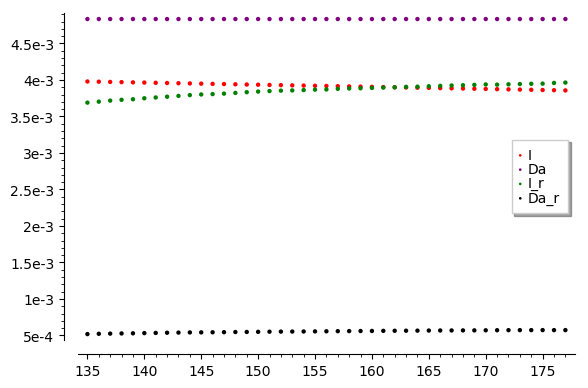

In [13]:
pop = 60461828
tspan = [135, 177]
real_data = np.genfromtxt('data.csv', delimiter=',')[1:]
data = []
inits = T.solution[-1][1]

for k in real_data:
    if tspan[0] <= k[0] <= tspan[1]:
        data.append((k[0], k[1]/pop, k[3]/pop))

def residual(params, data):
    B0 = params[0]
    Ti = params[1]
    t0 = params[2]
    alpha = params[3]
    rho = params[4]
    f = params[5]
    
    T = ode_solver()
    T.function = model
    T.ode_solve(tspan, inits, num_points = tspan[1] - tspan[0], params = [B0, Ti, t0, alpha, rho, f])
    
    model_out_0 = [(k[0], k[1][0]) for k in T.solution]
    model_out_1 = [(k[0], k[1][1]) for k in T.solution]
    model_out_2 = [(k[0], k[1][2]) for k in T.solution]
    model_out_3 = [(k[0], k[1][3]) for k in T.solution]
    model_out_4 = [(k[0], k[1][4]) for k in T.solution]
    model_out_5 = [(k[0], k[1][5]) for k in T.solution]
    
    erro_I = 0
    erro_D = 0
    for i in range(tspan[1] - tspan[0]):
        erro_I += (model_out_2[i][1] - data[i][1])**2
        erro_D += (model_out_5[i][1] - data[i][2])**2
    
    return erro_I + erro_D

x0 = [2, 14, 23, 0.2, 0.2, 0.05]

cons = ({'type': 'ineq', 'fun': lambda x0: x0[0]},
        {'type': 'ineq', 'fun': lambda x0: x0[1]},
        {'type': 'ineq', 'fun': lambda x0: x0[2] - 1},
        {'type': 'ineq', 'fun': lambda x0: - x0[2] + 30},
        {'type': 'ineq', 'fun': lambda x0: x0[3]},
        {'type': 'ineq', 'fun': lambda x0: x0[4]},
        {'type': 'ineq', 'fun': lambda x0: x0[5]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[3]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[4]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[5]}
        )

res = minimize(residual, x0, method = 'SLSQP', args = data, tol = 1e-10, constraints = cons)
params = res.x

T = ode_solver()
T.function = model
T.ode_solve(tspan, inits, num_points = tspan[1] - tspan[0], params = res.x)

model_out_0 = [(k[0], k[1][0]) for k in T.solution]
model_out_1 = [(k[0], k[1][1]) for k in T.solution]
model_out_2 = [(k[0], k[1][2]) for k in T.solution]
model_out_3 = [(k[0], k[1][3]) for k in T.solution]
model_out_4 = [(k[0], k[1][4]) for k in T.solution]
model_out_5 = [(k[0], k[1][5]) for k in T.solution]

plot0 = list_plot(model_out_0, color = 'green', pointsize = 10, alpha = 1, legend_label = 'S')
plot1 = list_plot(model_out_1, color = 'yellow', pointsize = 10, alpha = 1, legend_label = 'E')
plot2 = list_plot(model_out_2, color = 'red', pointsize = 10, alpha = 1, legend_label = 'I')
plot3 = list_plot(model_out_3, color = 'blue', pointsize = 10, alpha = 1, legend_label = 'R')
plot4 = list_plot(model_out_4, color = 'black', pointsize = 10, alpha = 1, legend_label = 'D')
plot5 = list_plot(model_out_5, color = 'purple', pointsize = 10, alpha = 1, legend_label = 'Da')

plot0.legend()
plot1.legend()
plot2.legend()
plot3.legend()
plot4.legend()
plot5.legend()

# show(plot0 + plot1 + plot2 + plot3 + plot4 + plot5)
# show(plot2 + plot5)

data1 = [(item[0], item[1]) for item in data]
data2 = [(item[0], item[2]) for item in data]

plot6 = list_plot(data1, color = 'green', pointsize = 10, alpha = 1, legend_label = 'I_r')
plot7 = list_plot(data2, color = 'black', pointsize = 10, alpha = 1, legend_label = 'Da_r')

plot6.legend()
plot7.legend()

show(plot2 + plot5 + plot6 + plot7)

/opt/sagemath-9.0/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:57: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


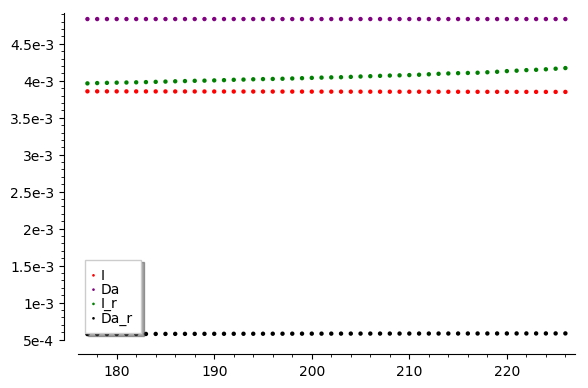

In [14]:
pop = 60461828
tspan = [177, 226]
real_data = np.genfromtxt('data.csv', delimiter=',')[1:]
data = []
inits = T.solution[-1][1]

for k in real_data:
    if tspan[0] <= k[0] <= tspan[1]:
        data.append((k[0], k[1]/pop, k[3]/pop))

def residual(params, data):
    B0 = params[0]
    Ti = params[1]
    t0 = params[2]
    alpha = params[3]
    rho = params[4]
    f = params[5]
    
    T = ode_solver()
    T.function = model
    T.ode_solve(tspan, inits, num_points = tspan[1] - tspan[0], params = [B0, Ti, t0, alpha, rho, f])
    
    model_out_0 = [(k[0], k[1][0]) for k in T.solution]
    model_out_1 = [(k[0], k[1][1]) for k in T.solution]
    model_out_2 = [(k[0], k[1][2]) for k in T.solution]
    model_out_3 = [(k[0], k[1][3]) for k in T.solution]
    model_out_4 = [(k[0], k[1][4]) for k in T.solution]
    model_out_5 = [(k[0], k[1][5]) for k in T.solution]
    
    erro_I = 0
    erro_D = 0
    for i in range(tspan[1] - tspan[0]):
        erro_I += (model_out_2[i][1] - data[i][1])**2
        erro_D += (model_out_5[i][1] - data[i][2])**2
    
    return erro_I + erro_D

x0 = [2, 14, 23, 0.2, 0.2, 0.05]

cons = ({'type': 'ineq', 'fun': lambda x0: x0[0]},
        {'type': 'ineq', 'fun': lambda x0: x0[1]},
        {'type': 'ineq', 'fun': lambda x0: x0[2] - 1},
        {'type': 'ineq', 'fun': lambda x0: - x0[2] + 30},
        {'type': 'ineq', 'fun': lambda x0: x0[3]},
        {'type': 'ineq', 'fun': lambda x0: x0[4]},
        {'type': 'ineq', 'fun': lambda x0: x0[5]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[3]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[4]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[5]}
        )

res = minimize(residual, x0, method = 'SLSQP', args = data, tol = 1e-10, constraints = cons)
params = res.x

T = ode_solver()
T.function = model
T.ode_solve(tspan, inits, num_points = tspan[1] - tspan[0], params = res.x)

model_out_0 = [(k[0], k[1][0]) for k in T.solution]
model_out_1 = [(k[0], k[1][1]) for k in T.solution]
model_out_2 = [(k[0], k[1][2]) for k in T.solution]
model_out_3 = [(k[0], k[1][3]) for k in T.solution]
model_out_4 = [(k[0], k[1][4]) for k in T.solution]
model_out_5 = [(k[0], k[1][5]) for k in T.solution]

plot0 = list_plot(model_out_0, color = 'green', pointsize = 10, alpha = 1, legend_label = 'S')
plot1 = list_plot(model_out_1, color = 'yellow', pointsize = 10, alpha = 1, legend_label = 'E')
plot2 = list_plot(model_out_2, color = 'red', pointsize = 10, alpha = 1, legend_label = 'I')
plot3 = list_plot(model_out_3, color = 'blue', pointsize = 10, alpha = 1, legend_label = 'R')
plot4 = list_plot(model_out_4, color = 'black', pointsize = 10, alpha = 1, legend_label = 'D')
plot5 = list_plot(model_out_5, color = 'purple', pointsize = 10, alpha = 1, legend_label = 'Da')

plot0.legend()
plot1.legend()
plot2.legend()
plot3.legend()
plot4.legend()
plot5.legend()

# show(plot0 + plot1 + plot2 + plot3 + plot4 + plot5)
# show(plot2 + plot5)

data1 = [(item[0], item[1]) for item in data]
data2 = [(item[0], item[2]) for item in data]

plot6 = list_plot(data1, color = 'green', pointsize = 10, alpha = 1, legend_label = 'I_r')
plot7 = list_plot(data2, color = 'black', pointsize = 10, alpha = 1, legend_label = 'Da_r')

plot6.legend()
plot7.legend()

show(plot2 + plot5 + plot6 + plot7)

/opt/sagemath-9.0/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:57: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


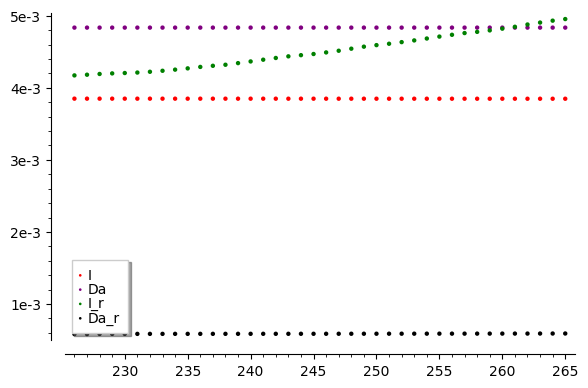

In [15]:
pop = 60461828
tspan = [226, 265]
real_data = np.genfromtxt('data.csv', delimiter=',')[1:]
data = []
inits = T.solution[-1][1]

for k in real_data:
    if tspan[0] <= k[0] <= tspan[1]:
        data.append((k[0], k[1]/pop, k[3]/pop))

def residual(params, data):
    B0 = params[0]
    Ti = params[1]
    t0 = params[2]
    alpha = params[3]
    rho = params[4]
    f = params[5]
    
    T = ode_solver()
    T.function = model
    T.ode_solve(tspan, inits, num_points = tspan[1] - tspan[0], params = [B0, Ti, t0, alpha, rho, f])
    
    model_out_0 = [(k[0], k[1][0]) for k in T.solution]
    model_out_1 = [(k[0], k[1][1]) for k in T.solution]
    model_out_2 = [(k[0], k[1][2]) for k in T.solution]
    model_out_3 = [(k[0], k[1][3]) for k in T.solution]
    model_out_4 = [(k[0], k[1][4]) for k in T.solution]
    model_out_5 = [(k[0], k[1][5]) for k in T.solution]
    
    erro_I = 0
    erro_D = 0
    for i in range(tspan[1] - tspan[0]):
        erro_I += (model_out_2[i][1] - data[i][1])**2
        erro_D += (model_out_5[i][1] - data[i][2])**2
    
    return erro_I + erro_D

x0 = [2, 14, 23, 0.2, 0.2, 0.05]

cons = ({'type': 'ineq', 'fun': lambda x0: x0[0]},
        {'type': 'ineq', 'fun': lambda x0: x0[1]},
        {'type': 'ineq', 'fun': lambda x0: x0[2] - 1},
        {'type': 'ineq', 'fun': lambda x0: - x0[2] + 30},
        {'type': 'ineq', 'fun': lambda x0: x0[3]},
        {'type': 'ineq', 'fun': lambda x0: x0[4]},
        {'type': 'ineq', 'fun': lambda x0: x0[5]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[3]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[4]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[5]}
        )

res = minimize(residual, x0, method = 'SLSQP', args = data, tol = 1e-10, constraints = cons)
params = res.x

T = ode_solver()
T.function = model
T.ode_solve(tspan, inits, num_points = tspan[1] - tspan[0], params = res.x)

model_out_0 = [(k[0], k[1][0]) for k in T.solution]
model_out_1 = [(k[0], k[1][1]) for k in T.solution]
model_out_2 = [(k[0], k[1][2]) for k in T.solution]
model_out_3 = [(k[0], k[1][3]) for k in T.solution]
model_out_4 = [(k[0], k[1][4]) for k in T.solution]
model_out_5 = [(k[0], k[1][5]) for k in T.solution]

plot0 = list_plot(model_out_0, color = 'green', pointsize = 10, alpha = 1, legend_label = 'S')
plot1 = list_plot(model_out_1, color = 'yellow', pointsize = 10, alpha = 1, legend_label = 'E')
plot2 = list_plot(model_out_2, color = 'red', pointsize = 10, alpha = 1, legend_label = 'I')
plot3 = list_plot(model_out_3, color = 'blue', pointsize = 10, alpha = 1, legend_label = 'R')
plot4 = list_plot(model_out_4, color = 'black', pointsize = 10, alpha = 1, legend_label = 'D')
plot5 = list_plot(model_out_5, color = 'purple', pointsize = 10, alpha = 1, legend_label = 'Da')

plot0.legend()
plot1.legend()
plot2.legend()
plot3.legend()
plot4.legend()
plot5.legend()

# show(plot0 + plot1 + plot2 + plot3 + plot4 + plot5)
# show(plot2 + plot5)

data1 = [(item[0], item[1]) for item in data]
data2 = [(item[0], item[2]) for item in data]

plot6 = list_plot(data1, color = 'green', pointsize = 10, alpha = 1, legend_label = 'I_r')
plot7 = list_plot(data2, color = 'black', pointsize = 10, alpha = 1, legend_label = 'Da_r')

plot6.legend()
plot7.legend()

show(plot2 + plot5 + plot6 + plot7)

/opt/sagemath-9.0/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:57: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


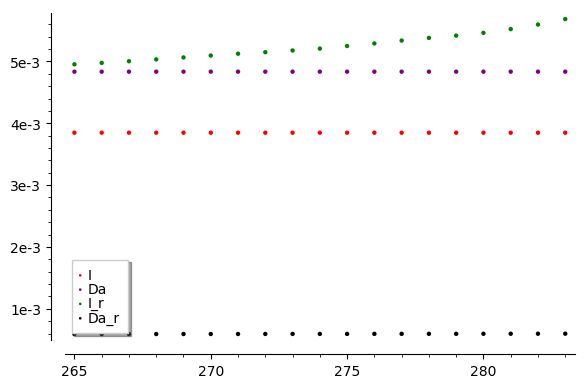

In [16]:
pop = 60461828
tspan = [265, 283]
real_data = np.genfromtxt('data.csv', delimiter=',')[1:]
data = []
inits = T.solution[-1][1]

for k in real_data:
    if tspan[0] <= k[0] <= tspan[1]:
        data.append((k[0], k[1]/pop, k[3]/pop))

def residual(params, data):
    B0 = params[0]
    Ti = params[1]
    t0 = params[2]
    alpha = params[3]
    rho = params[4]
    f = params[5]
    
    T = ode_solver()
    T.function = model
    T.ode_solve(tspan, inits, num_points = tspan[1] - tspan[0], params = [B0, Ti, t0, alpha, rho, f])
    
    model_out_0 = [(k[0], k[1][0]) for k in T.solution]
    model_out_1 = [(k[0], k[1][1]) for k in T.solution]
    model_out_2 = [(k[0], k[1][2]) for k in T.solution]
    model_out_3 = [(k[0], k[1][3]) for k in T.solution]
    model_out_4 = [(k[0], k[1][4]) for k in T.solution]
    model_out_5 = [(k[0], k[1][5]) for k in T.solution]
    
    erro_I = 0
    erro_D = 0
    for i in range(tspan[1] - tspan[0]):
        erro_I += (model_out_2[i][1] - data[i][1])**2
        erro_D += (model_out_5[i][1] - data[i][2])**2
    
    return erro_I + erro_D

x0 = [2, 14, 23, 0.2, 0.2, 0.05]

cons = ({'type': 'ineq', 'fun': lambda x0: x0[0]},
        {'type': 'ineq', 'fun': lambda x0: x0[1]},
        {'type': 'ineq', 'fun': lambda x0: x0[2] - 1},
        {'type': 'ineq', 'fun': lambda x0: - x0[2] + 30},
        {'type': 'ineq', 'fun': lambda x0: x0[3]},
        {'type': 'ineq', 'fun': lambda x0: x0[4]},
        {'type': 'ineq', 'fun': lambda x0: x0[5]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[3]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[4]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[5]}
        )

res = minimize(residual, x0, method = 'SLSQP', args = data, tol = 1e-10, constraints = cons)
params = res.x

T = ode_solver()
T.function = model
T.ode_solve(tspan, inits, num_points = tspan[1] - tspan[0], params = res.x)

model_out_0 = [(k[0], k[1][0]) for k in T.solution]
model_out_1 = [(k[0], k[1][1]) for k in T.solution]
model_out_2 = [(k[0], k[1][2]) for k in T.solution]
model_out_3 = [(k[0], k[1][3]) for k in T.solution]
model_out_4 = [(k[0], k[1][4]) for k in T.solution]
model_out_5 = [(k[0], k[1][5]) for k in T.solution]

plot0 = list_plot(model_out_0, color = 'green', pointsize = 10, alpha = 1, legend_label = 'S')
plot1 = list_plot(model_out_1, color = 'yellow', pointsize = 10, alpha = 1, legend_label = 'E')
plot2 = list_plot(model_out_2, color = 'red', pointsize = 10, alpha = 1, legend_label = 'I')
plot3 = list_plot(model_out_3, color = 'blue', pointsize = 10, alpha = 1, legend_label = 'R')
plot4 = list_plot(model_out_4, color = 'black', pointsize = 10, alpha = 1, legend_label = 'D')
plot5 = list_plot(model_out_5, color = 'purple', pointsize = 10, alpha = 1, legend_label = 'Da')

plot0.legend()
plot1.legend()
plot2.legend()
plot3.legend()
plot4.legend()
plot5.legend()

# show(plot0 + plot1 + plot2 + plot3 + plot4 + plot5)
# show(plot2 + plot5)

data1 = [(item[0], item[1]) for item in data]
data2 = [(item[0], item[2]) for item in data]

plot6 = list_plot(data1, color = 'green', pointsize = 10, alpha = 1, legend_label = 'I_r')
plot7 = list_plot(data2, color = 'black', pointsize = 10, alpha = 1, legend_label = 'Da_r')

plot6.legend()
plot7.legend()

show(plot2 + plot5 + plot6 + plot7)

/opt/sagemath-9.0/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:57: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


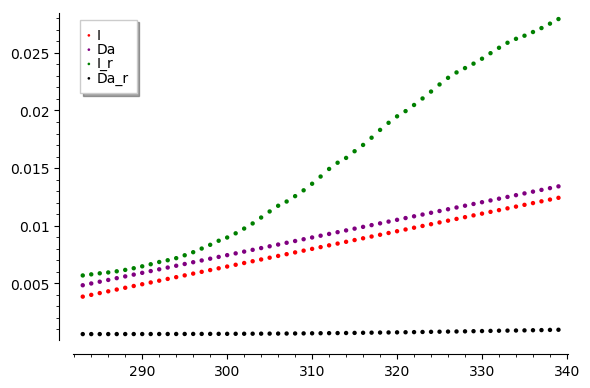

In [17]:
pop = 60461828
tspan = [283, 339]
real_data = np.genfromtxt('data.csv', delimiter=',')[1:]
data = []
inits = T.solution[-1][1]

for k in real_data:
    if tspan[0] <= k[0] <= tspan[1]:
        data.append((k[0], k[1]/pop, k[3]/pop))

def residual(params, data):
    B0 = params[0]
    Ti = params[1]
    t0 = params[2]
    alpha = params[3]
    rho = params[4]
    f = params[5]
    
    T = ode_solver()
    T.function = model
    T.ode_solve(tspan, inits, num_points = tspan[1] - tspan[0], params = [B0, Ti, t0, alpha, rho, f])
    
    model_out_0 = [(k[0], k[1][0]) for k in T.solution]
    model_out_1 = [(k[0], k[1][1]) for k in T.solution]
    model_out_2 = [(k[0], k[1][2]) for k in T.solution]
    model_out_3 = [(k[0], k[1][3]) for k in T.solution]
    model_out_4 = [(k[0], k[1][4]) for k in T.solution]
    model_out_5 = [(k[0], k[1][5]) for k in T.solution]
    
    erro_I = 0
    erro_D = 0
    for i in range(tspan[1] - tspan[0]):
        erro_I += (model_out_2[i][1] - data[i][1])**2
        erro_D += (model_out_5[i][1] - data[i][2])**2
    
    return erro_I + erro_D

x0 = [2, 14, 23, 0.2, 0.2, 0.05]

cons = ({'type': 'ineq', 'fun': lambda x0: x0[0]},
        {'type': 'ineq', 'fun': lambda x0: x0[1]},
        {'type': 'ineq', 'fun': lambda x0: x0[2] - 1},
        {'type': 'ineq', 'fun': lambda x0: - x0[2] + 30},
        {'type': 'ineq', 'fun': lambda x0: x0[3]},
        {'type': 'ineq', 'fun': lambda x0: x0[4]},
        {'type': 'ineq', 'fun': lambda x0: x0[5]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[3]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[4]},
        {'type': 'ineq', 'fun': lambda x0: 1 - x0[5]}
        )

res = minimize(residual, x0, method = 'SLSQP', args = data, tol = 1e-10, constraints = cons)
params = res.x

T = ode_solver()
T.function = model
T.ode_solve(tspan, inits, num_points = tspan[1] - tspan[0], params = res.x)

model_out_0 = [(k[0], k[1][0]) for k in T.solution]
model_out_1 = [(k[0], k[1][1]) for k in T.solution]
model_out_2 = [(k[0], k[1][2]) for k in T.solution]
model_out_3 = [(k[0], k[1][3]) for k in T.solution]
model_out_4 = [(k[0], k[1][4]) for k in T.solution]
model_out_5 = [(k[0], k[1][5]) for k in T.solution]

plot0 = list_plot(model_out_0, color = 'green', pointsize = 10, alpha = 1, legend_label = 'S')
plot1 = list_plot(model_out_1, color = 'yellow', pointsize = 10, alpha = 1, legend_label = 'E')
plot2 = list_plot(model_out_2, color = 'red', pointsize = 10, alpha = 1, legend_label = 'I')
plot3 = list_plot(model_out_3, color = 'blue', pointsize = 10, alpha = 1, legend_label = 'R')
plot4 = list_plot(model_out_4, color = 'black', pointsize = 10, alpha = 1, legend_label = 'D')
plot5 = list_plot(model_out_5, color = 'purple', pointsize = 10, alpha = 1, legend_label = 'Da')

plot0.legend()
plot1.legend()
plot2.legend()
plot3.legend()
plot4.legend()
plot5.legend()

# show(plot0 + plot1 + plot2 + plot3 + plot4 + plot5)
# show(plot2 + plot5)

data1 = [(item[0], item[1]) for item in data]
data2 = [(item[0], item[2]) for item in data]

plot6 = list_plot(data1, color = 'green', pointsize = 10, alpha = 1, legend_label = 'I_r')
plot7 = list_plot(data2, color = 'black', pointsize = 10, alpha = 1, legend_label = 'Da_r')

plot6.legend()
plot7.legend()

show(plot2 + plot5 + plot6 + plot7)